# Example usage
Here is a demonstration of using "organage" to estimate organ-specific biological age from SomaScan data. 

"organage" requires SomaScan v4 (5k proteins) or v4.1 (7k proteins) data. 

In [159]:
from organage import OrganAge
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
from scipy import stats
import numpy as np


# Load data

### sample x metadata dataframe
- index should be sample name
- "Age" and "Sex_F" are required columns in this dataframe.
- other columns are optional

In [143]:
md_hot = pd.read_csv("../tests/md_hot.csv")
md_hot = md_hot.set_index("ID")
md_hot.head()

,Age,Sex_F
ID,,
0,75,0
1,83,0
2,83,0
3,68,0
4,89,0


### sample x protein expression dataframe
- index should be sample name
- columns should be "SeqId"s from SomaScan data. 
- values should be ANML normalized expression data in RFU units. These values are the raw values from the '.anmlSMP.adat' file provided by Somalogic


In [144]:
df_prot = pd.read_csv("../tests/df_prot.csv")
df_prot = df_prot.set_index("ID")
df_prot.head()

,10000-28,10001-7,10003-15,10006-25,10008-43,10011-65,10012-5,10014-31,10015-119,10022-207,...,9981-18,9983-97,9984-12,9986-14,9989-12,9993-11,9994-217,9995-6,9997-12,9999-1
ID,,,,,,,,,,,,,,,,,,,,,
0,478.5,300.9,154.9,777.3,489.2,2614.4,1066.3,791.3,528.0,241.8,...,996.9,646.4,432.3,8696.0,382.1,945.6,1686.0,2000.0,15434.4,1522.3
1,532.8,399.4,204.8,592.6,409.6,3386.8,1539.6,834.5,523.8,224.1,...,742.6,662.4,1944.9,4866.0,493.3,989.6,1308.6,1725.6,6564.7,2033.3
2,564.7,283.5,157.1,6085.3,490.7,2683.7,1347.4,900.4,898.9,239.9,...,541.1,470.4,563.2,7664.7,536.3,1163.4,1126.3,1827.3,12639.8,1927.2
3,645.6,303.0,134.5,634.4,732.6,3107.0,1559.3,785.4,471.2,238.0,...,528.3,571.6,645.3,2533.6,491.9,971.6,1068.7,1184.0,10789.1,1067.6
4,544.6,372.8,164.8,491.8,424.8,1844.3,1723.3,862.0,989.6,141.2,...,381.5,469.8,600.7,4424.6,577.2,2049.7,1273.2,1787.5,10082.2,1966.7


# Calculate organ age gaps


In [145]:
data = OrganAge.CreateOrganAgeObject()
#data.add_data(md_noise_hot, df_prot_noise_input)
data.add_data(md_hot, df_prot)
data.normalize(assay_version="v4.1")  #requires "v4" or "v4.1"
res = data.estimate_organ_ages()
res

Adipose...
Artery...
Brain...
Heart...
Immune...
Intestine...
Kidney...
Liver...
Lung...
Muscle...
Pancreas...
Organismal...
Conventional...
CognitionAdipose...
CognitionArtery...
CognitionBrain...
CognitionHeart...
CognitionImmune...
CognitionIntestine...
CognitionKidney...
CognitionLiver...
CognitionLung...
CognitionMuscle...
CognitionPancreas...
CognitionOrganismal...


,Age,Sex_F,Predicted_Age,yhat_lowess,AgeGap,AgeGap_zscored,Organ
ID,,,,,,,
0,75,0,70.923905,72.884334,-1.960429,-0.450277,Adipose
1,83,0,79.501132,75.955270,3.545862,0.814424,Adipose
2,83,0,88.710218,75.955270,12.754948,2.929596,Adipose
3,68,0,79.572353,71.214231,8.358123,1.919719,Adipose
4,89,0,68.964994,78.491385,-9.526392,-2.188051,Adipose
...,...,...,...,...,...,...,...
195,72,0,66.977918,71.406521,-4.428602,-1.044610,CognitionOrganismal
196,80,0,82.426143,77.640418,4.785726,1.128848,CognitionOrganismal
197,77,1,79.479482,75.193409,4.286073,1.010991,CognitionOrganismal


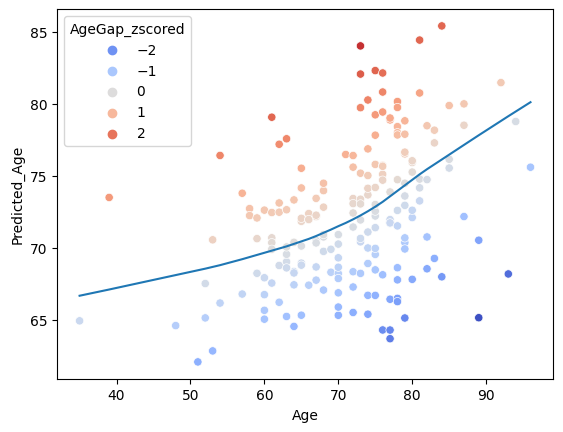

In [231]:
toplot = res.loc[res.Organ=="Heart"]
toplot = toplot.sort_values("Age")
sns.scatterplot(data=toplot, x="Age", y="Predicted_Age", 
                hue="AgeGap_zscored", palette='coolwarm', hue_norm=(-3,3))                
plt.plot(toplot.Age, toplot.yhat_lowess)
plt.show()


# Recalculate age gap based on cohort age gap distribution
The default method for this package calculates age gaps based on the distribution of predicted ages from the models' training cohort. 


It may be necessary to recalculate age gaps based on the distribution of the desired cohort if there are strong cohort effects. We show how to do this below.
1. for each organ...
2. derive lowess curve for predicted versus chronological age within a single cohort
3. calculate age gap as the predicted age - lowess curve
4. z-score

In [232]:
todf=[]
FRAC=2/3

#for each organ
for organ in set(res.Organ):
    res_sub = res.loc[res.Organ==organ].copy()

    #lowess curve
    lowess = sm.nonparametric.lowess
    lowess_fit=lowess(res_sub.Predicted_Age.to_numpy(), res_sub.Age.to_numpy(), frac=FRAC, it=5)
    lowess_fit_int = interp1d(lowess_fit[:,0], lowess_fit[:,1], bounds_error=False, kind='linear', fill_value='extrapolate') 
    y_lowess=lowess_fit_int(res_sub.Age)
    res_sub["yhat_lowess_cohort"] = y_lowess

    #age gap
    res_sub["AgeGap_cohort"] = res_sub["Predicted_Age"] - res_sub["yhat_lowess_cohort"]

    #z-score
    res_sub["AgeGap_cohort_zscored"] = stats.zscore(res_sub["AgeGap_cohort"])
    todf.append(res_sub)

res_all = pd.concat(todf)
res_all


,Age,Sex_F,Predicted_Age,yhat_lowess,AgeGap,AgeGap_zscored,Organ,yhat_lowess_cohort,AgeGap_cohort,AgeGap_cohort_zscored
ID,,,,,,,,,,
0,75,0,71.963223,72.876658,-0.913434,-0.193536,CognitionBrain,71.466302,0.496922,0.128274
1,83,0,74.991900,76.266803,-1.274903,-0.270123,CognitionBrain,73.470695,1.521205,0.342543
2,83,0,79.375817,76.266803,3.109014,0.658730,CognitionBrain,73.470695,5.905122,1.259608
3,68,0,75.901124,70.819081,5.082042,1.076771,CognitionBrain,70.276063,5.625060,1.201022
4,89,0,73.592799,79.067759,-5.474960,-1.160021,CognitionBrain,74.701328,-1.108529,-0.207568
...,...,...,...,...,...,...,...,...,...,...
195,72,0,68.319035,71.603768,-3.284733,-0.904908,Organismal,71.918435,-3.599400,-0.817613
196,80,0,82.876144,78.367784,4.508360,1.242005,Organismal,76.892567,5.983576,1.275237
197,77,1,78.065414,75.761939,2.303475,0.634582,Organismal,75.147428,2.917985,0.605735


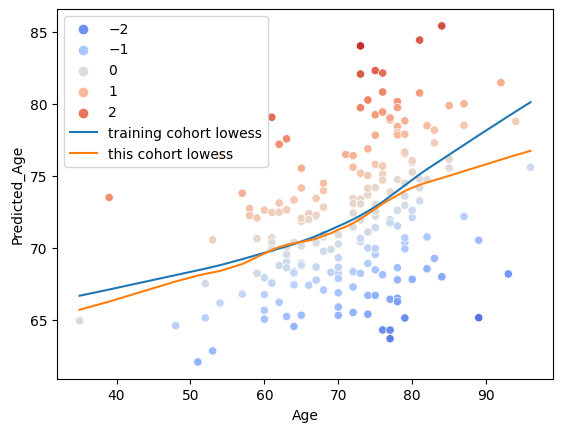

In [233]:
toplot = res_all.loc[res_all.Organ=="Heart"]
toplot = toplot.sort_values("Age")
sns.scatterplot(data=toplot, x="Age", y="Predicted_Age", 
                hue="AgeGap_cohort_zscored", palette='coolwarm', hue_norm=(-3,3))                
plt.plot(toplot.Age, toplot.yhat_lowess, label="training cohort lowess")
plt.plot(toplot.Age, toplot.yhat_lowess_cohort, label="this cohort lowess")
plt.legend()
plt.show()


lowess regression may be unnecessary if the distribution is linear, and/or lowess may be overfit with low sample size. 

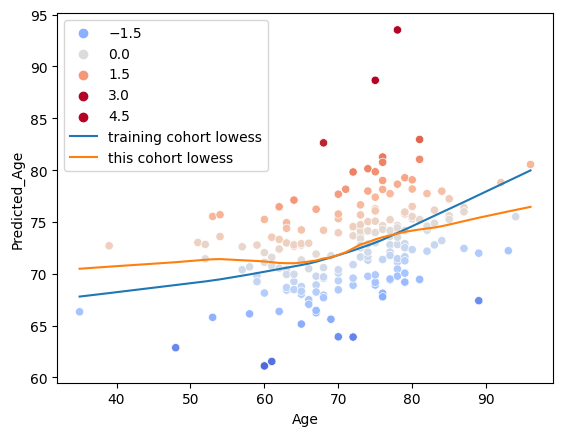

In [234]:
#ie. low sample size causes Artery lowess to overfit
toplot = res_all.loc[res_all.Organ=="Artery"]
toplot = toplot.sort_values("Age")
sns.scatterplot(data=toplot, x="Age", y="Predicted_Age", 
                hue="AgeGap_cohort_zscored", palette='coolwarm', hue_norm=(-3,3))                
plt.plot(toplot.Age, toplot.yhat_lowess, label="training cohort lowess")
plt.plot(toplot.Age, toplot.yhat_lowess_cohort, label="this cohort lowess")
plt.legend()
plt.show()


can either increase lowess paramter "frac" to 1 or use linear regression.

In [235]:
#linear regression of predicted versus chronological age
todf=[]

#for each organ
for organ in set(res.Organ):
    res_sub = res.loc[res.Organ==organ].copy()

    #lowess curve
    ols = sm.OLS(res_sub.Predicted_Age, sm.add_constant(res_sub[["Age"]])).fit()    
    res_sub["yhat_linear_cohort"] = ols.predict(sm.add_constant(res_sub[["Age"]]))

    #age gap
    res_sub["AgeGap_cohort"] = ols.resid

    #z-score
    res_sub["AgeGap_cohort_zscored"] = stats.zscore(res_sub["AgeGap_cohort"])
    todf.append(res_sub)

res_all = pd.concat(todf)
res_all


,Age,Sex_F,Predicted_Age,yhat_lowess,AgeGap,AgeGap_zscored,Organ,yhat_linear_cohort,AgeGap_cohort,AgeGap_cohort_zscored
ID,,,,,,,,,,
0,75,0,71.963223,72.876658,-0.913434,-0.193536,CognitionBrain,71.977252,-0.014029,-0.002962
1,83,0,74.991900,76.266803,-1.274903,-0.270123,CognitionBrain,73.347668,1.644232,0.347202
2,83,0,79.375817,76.266803,3.109014,0.658730,CognitionBrain,73.347668,6.028149,1.272927
3,68,0,75.901124,70.819081,5.082042,1.076771,CognitionBrain,70.778138,5.122985,1.081789
4,89,0,73.592799,79.067759,-5.474960,-1.160021,CognitionBrain,74.375480,-0.782681,-0.165274
...,...,...,...,...,...,...,...,...,...,...
195,72,0,68.319035,71.603768,-3.284733,-0.904908,Organismal,72.843681,-4.524646,-0.976891
196,80,0,82.876144,78.367784,4.508360,1.242005,Organismal,76.932921,5.943222,1.283168
197,77,1,78.065414,75.761939,2.303475,0.634582,Organismal,75.399456,2.665958,0.575592


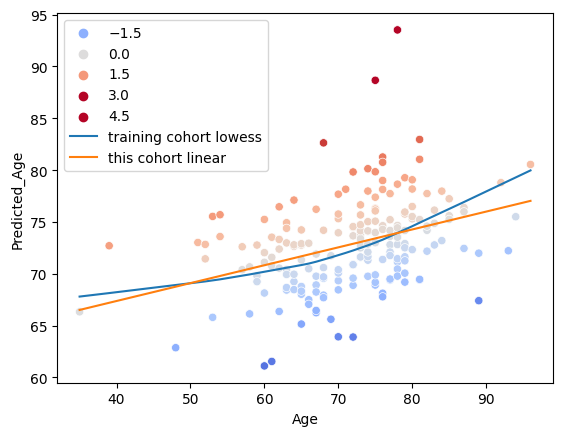

In [236]:
toplot = res_all.loc[res_all.Organ=="Artery"]
toplot = toplot.sort_values("Age")
sns.scatterplot(data=toplot, x="Age", y="Predicted_Age", 
                hue="AgeGap_cohort_zscored", palette='coolwarm', hue_norm=(-3,3))
plt.plot(toplot.Age, toplot.yhat_lowess, label="training cohort lowess")
plt.plot(toplot.Age, toplot.yhat_linear_cohort, label="this cohort linear")
plt.legend()
plt.show()
